# **LOAD the Files From Github**

---



In [ ]:
!git clone https://github.com/JapsimarSinghWahi/DeepSteganography.git

Cloning into 'DeepSteganography'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 46 (delta 18), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (46/46), 6.31 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (18/18), done.


# **Load the DIV2k Dataset From Kaggle**

In [ ]:
!pip install kaggle

# Move the API key file to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# Download the Kaggle dataset

!kaggle datasets download -d joe1995/div2k-dataset

In [ ]:
!unzip /content/div2k-dataset.zip -d destination-path

In [ ]:
### Imports ###
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

# **Division of Dataset**

In [ ]:
from tensorflow.keras.preprocessing import image
import os
import random
import numpy as np

from PIL import Image  # Importing Pillow aas 'Image'

# Constants
TRAIN_DIR = "/content/destination-path/DIV2K_train_HR/DIV2K_train_HR"
VALID_DIR = "/content/destination-path/DIV2K_valid_HR/DIV2K_valid_HR"  # Path to training directory
IMG_SHAPE = (64, 64)

def load_dataset(batch_size=32):
    """Loads the training dataset in batches.

    Arguments:
        batch_size: number of images per batch to load into the training dataset.
    """
    X_train = []
    X_val = []

    # Assuming all images are directly within the TRAIN_DIR
    train_imgs = os.listdir(TRAIN_DIR)
    valid_imgs = os.listdir(VALID_DIR)
    random.shuffle(train_imgs)
    random.shuffle(valid_imgs)

    num_train_batches = len(train_imgs) // batch_size
    num_valid_batches = len(valid_imgs) // batch_size


    for batch in range(num_train_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size

        batch_imgs = train_imgs[start_idx:end_idx]

        for img_name_i in batch_imgs:
            img_path_i = os.path.join(TRAIN_DIR, img_name_i)

            try:
                # Open image using Pillow
                img_i = Image.open(img_path_i)
                # Resize image
                img_i = img_i.resize(IMG_SHAPE)
                # Convert to numpy array
                x = np.array(img_i)
                X_train.append(x)
            except Exception as e:
                print(f"Error loading image {img_path_i}: {e}")

    X_train = np.array(X_train)

    for batch in range(num_valid_batches):
          start_idx = batch * batch_size
          end_idx = (batch + 1) * batch_size

          batch_imgs = valid_imgs[start_idx:end_idx]

          for img_name_i in batch_imgs:
              img_path_i = os.path.join(VALID_DIR, img_name_i)

              try:
                  # Open image using Pillow
                  img_i = Image.open(img_path_i)
                  # Resize image
                  img_i = img_i.resize(IMG_SHAPE)
                  # Convert to numpy array
                  x = np.array(img_i)
                  X_val.append(x)
              except Exception as e:
                  print(f"Error loading image {img_path_i}: {e}")

    # Convert the list to a numpy array

    X_val = np.array(X_val)
    return X_train, X_val

# Example usage:
batch_size = 32  # Adjust as needed
X_train, X_val = load_dataset(batch_size)


In [ ]:
X_val.shape

In [ ]:
  # Load dataset.
  # X_train_orig, X_test_orig = load_dataset_small()
  X_train_orig, X_val_orig = load_dataset()

  # Normalize image vectors.
  X_train = X_train_orig/255.
  X_val = X_val_orig/255.

  # Print statistics.
  print ("Number of training examples = " + str(X_train.shape[0]))
  print ("Number of test examples = " + str(X_val.shape[0]))
  print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 800
Number of test examples = 96
X_train shape: (800, 64, 64, 3)


In [ ]:
# Split the training set into two halves.
# The first half is used for secret images, and the second half for cover images.

# Secret Images
input_train_S1 = X_train[:X_train.shape[0] // 2]
input_val_S1 = X_val[:X_val.shape[0]//2]

# Cover Images
input_train_C = X_train[X_train.shape[0] // 2 :]
input_val_C = X_val[X_val.shape[0] // 2 :]



# **Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, concatenate, Dropout, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.nn import depth_to_space


# Constants
input_size = (64, 64, 3)  # Adjust the size as needed


#     return loss
def color_histogram_loss(y_true, y_pred, bins=256):
    # Ensure that the image pixel values are scaled to the range [0, 255] if they are originally [0, 1]
    y_true_int = tf.cast(y_true * 255, tf.int32)
    y_pred_int = tf.cast(y_pred * 255, tf.int32)

    # Calculate the histograms
    hist_true = tf.histogram_fixed_width(y_true_int, [0, 255], nbins=bins, dtype=tf.int32)
    hist_pred = tf.histogram_fixed_width(y_pred_int, [0, 255], nbins=bins, dtype=tf.int32)

    # Calculate the histogram loss as the mean squared difference between histograms
    # and make sure the result is float32
    loss = tf.cast(tf.reduce_mean(tf.square(hist_true - hist_pred)), tf.float32)

    return loss

def ssim_loss(y_true, y_pred):
    return 1 - K.mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Combined MSE, SSIM, and Histogram loss
def combined_loss(y_true, y_pred):
    alpha = 0.84  # Weight for SSIM
    beta = 0.1    # Weight for MSE
    gamma = 0.06  # Weight for color histogram loss, adjust as necessary

    mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)
    ssim_l = ssim_loss(y_true, y_pred)
    histogram_l = color_histogram_loss(y_true, y_pred)

    # Ensure all losses are float32 before combining
    mse_loss = K.cast(mse_loss, 'float32')
    ssim_l = K.cast(ssim_l, 'float32')
    histogram_l = K.cast(histogram_l, 'float32')

    # Combine the losses
    combined = alpha * mse_loss + beta * ssim_l + gamma * histogram_l

    return combined


def full_loss(y_true, y_pred):
    s_true, c_true = y_true[..., 0:3], y_true[..., 3:6]
    s_pred, c_pred = y_pred[..., 0:3], y_pred[..., 3:6]

    s_loss = combined_loss(s_true, s_pred)
    c_loss = combined_loss(c_true, c_pred)

    # Assuming you want to apply the same weighting to both perceptual losses
    alpha = 0.01  # You can adjust this weight
    return s_loss + c_loss


def SubpixelConv2D(scale):
    return Lambda(lambda x: depth_to_space(x, scale))

# Returns the encoder as a Keras model
def make_encoder(input_size):
    input_S1 = Input(shape=input_size, name='input_S1')
    input_C = Input(shape=input_size, name='input_C')

    # Preparation Network
    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_prep0_3x3_1')(input_S1)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_prep0_4x4_1')(input_S1)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_prep0_5x5_1')(input_S1)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x3)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here1')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_prep1_3x3_1')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_prep1_4x4_1')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_prep1_5x5_1')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here2')
    x1 = concatenate([x3, x4, x5])


    x = concatenate([input_C, x1])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid0_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid0_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid0_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here3')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid1_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid1_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid1_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here4')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid2_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid2_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid2_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here5')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid3_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid3_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid3_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here6')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid4_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid4_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid4_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here7')
    x = concatenate([x3, x4, x5])
    print('x3 : ', x3.shape)
    print('x : ', x.shape)
    xf = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='conv_hid_final')(x)

    # Adding Gaussian noise to the hidden image
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_Cp')(xf)
    print(output_Cprime.shape)

    return Model(inputs=[input_S1, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')
# Returns the decoder as a Keras model
def make_decoder(input_size):
    reveal_input = Input(shape=input_size, name='reveal_input')

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_rev0_3x3')(reveal_input)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_rev0_4x4')(reveal_input)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_rev0_5x5')(reveal_input)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_rev1_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.3)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_rev1_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x3)
    dropout_x4 = Dropout(0.3)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_rev1_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.3)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    xf = concatenate([x3, x4, x5])

    x = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='conv_rev_final')(xf)

    print(x.shape)
    return Model(inputs=reveal_input, outputs=x, name='Decoder')

# Full model (Autoencoder)
def make_model(input_size):
    input_S1 = Input(shape=input_size, name='input_S1')
    input_C = Input(shape=input_size, name='input_C')

    encoder = make_encoder(input_size)
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=combined_loss)


    hidden_image = encoder([input_S1, input_C])
    revealed_image = decoder(hidden_image)

    print('here')
    autoencoder = Model(inputs=[input_S1, input_C], outputs=concatenate([revealed_image, hidden_image]), name='Steganography_Model')
    autoencoder.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder, autoencoder



# **# Images from Dataset**

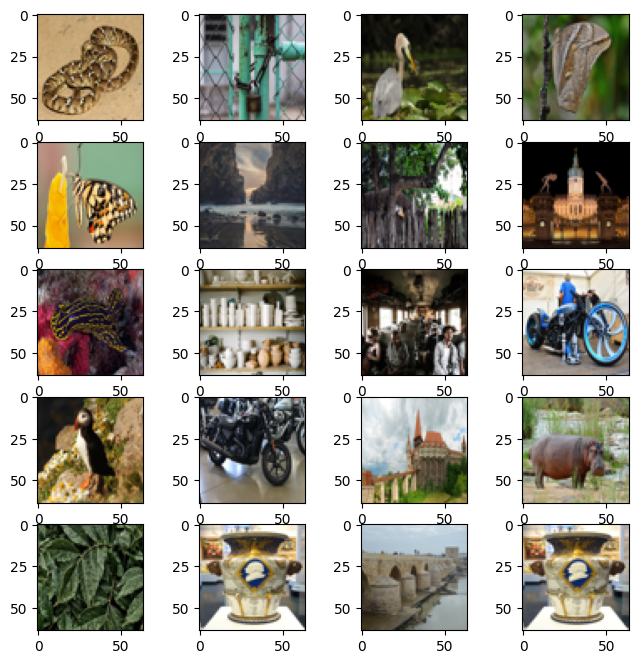

In [ ]:
# Show sample images from the training dataset
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:
encoder_model, reveal_model1, autoencoder_model = make_model(input_train_S1.shape[1:])

here1
here2
here3
here4
here5
here6
here7
x3 :  (None, 64, 64, 128)
x :  (None, 64, 64, 224)
(None, 64, 64, 3)
(None, 64, 64, 3)
here


# **Load the Saved Training Weights**

In [ ]:
autoencoder_model.load_weights("model450.h5")

Mounted at /content/drive


In [ ]:
reveal_model1.load_weights("modelreveal450.h5")

In [ ]:
encoder_model.load_weights("modelencoder450.h5")

In [ ]:
# def lr_schedule(epoch_idx):
#     if epoch_idx < 200:
#         return 0.001
#     elif epoch_idx < 400:
#         return 0.0003
#     elif epoch_idx < 600:
#         return 0.0001
#     else:
#         return 0.00003

def lr_schedule(epoch_idx):
    return 0.000003

In [ ]:
def display_progress(encoder, decoder, input_C, input_S1, epoch):
    # Choose a random index for visualization
    idx1 = np.random.choice(range(len(input_C)))
    idx2 = np.random.choice(range(len(input_S1)))

    # Get the images to be displayed
    cover_img = input_C[idx1]
    secret_img = input_S1[idx2]

    # Process the images through the network
    encoded_img = encoder.predict([cover_img[np.newaxis, ...], secret_img[np.newaxis, ...]])
    decoded = autoencoder_model.predict([cover_img[np.newaxis, ...], secret_img[np.newaxis, ...]])
    decoded_S1, decoded_C = decoded[..., 0:3], decoded[..., 3:6]

    # Squeeze out the batch dimension
    decoded_S1 = np.squeeze(decoded_S1, axis=0)
    decoded_C = np.squeeze(decoded_C, axis=0)

    # Plot the results
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 4, 1)
    plt.imshow(cover_img)
    plt.title("Cover")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(secret_img)
    plt.title("Secret")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(decoded_S1)
    plt.title("Encoded")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(decoded_C)
    plt.title("Decoded")
    plt.axis('off')

    plt.suptitle(f'Epoch: {epoch}')
    plt.show()

NB_EPOCHS = 50
BATCH_SIZE = 32

m_train = input_train_S1.shape[0]
m_val = input_val_S1.shape[0]
loss_history = []
#loss_history2 = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_train_S1)

    np.random.shuffle(input_train_C)

    t = tqdm(range(0, input_train_S1.shape[0], BATCH_SIZE),mininterval=0)
    v = tqdm(range(0, input_val_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_train_loss = []
    rev_train_loss = []
    rev_val_loss = []
    ae_val_loss = []
    for idx in t:

        batch_train_S1 = input_train_S1[idx:min(idx + BATCH_SIZE, m_train)]
        batch_train_C = input_train_C[idx:min(idx + BATCH_SIZE, m_train)]

        C_prime = encoder_model.predict([batch_train_S1,  batch_train_C])

        ae_train_loss.append(autoencoder_model.train_on_batch(x=[batch_train_S1, batch_train_C], y=np.concatenate((batch_train_S1, batch_train_C), axis=-1)))

        rev_train_loss.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_train_S1))


        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        #K.set_value(autoencoder_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))


        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f}'.format(epoch + 1, idx, m_train, np.mean(ae_train_loss), np.mean(rev_train_loss)))

    for idx in v:

        batch_val_S1 = input_val_S1[idx:min(idx + BATCH_SIZE, m_val)]
        batch_val_C = input_val_C[idx:min(idx + BATCH_SIZE, m_val)]

        ae_val_loss.append(autoencoder_model.evaluate(x=[batch_val_S1, batch_val_C], y=np.concatenate((batch_val_S1, batch_val_C), axis=-1)))
        rev_val_loss.append(reveal_model1.evaluate(x=encoder_model.predict([batch_val_S1, batch_val_C]), y=batch_val_S1))


    display_progress(encoder_model, reveal_model1, input_val_C, input_val_S1, epoch+1)

    # autoencoder_model.save("model150.h5")
    # autoencoder_model.save_weights("model.h5")

    # encoder_model.save_weights("modelencoder.h5")
    # encoder_model.save("modelencoder.h5")
    # reveal_model1.save("modelreveal.h5")

    # loss_history.append(np.mean(ae_train_loss))
    #loss_history2.append(np.mean(ae_loss2))

1/1 [==============================] - 0s 78ms/step


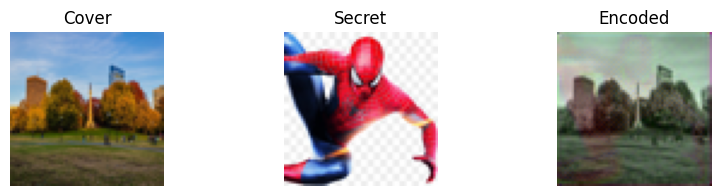

In [ ]:
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from PIL import ImageFilter
import matplotlib.pyplot as plt
import cv2

IMG_SHAPE = (64, 64)  # Make sure this is the same size as used in training

def preprocess_image(image_path):
    """Loads and preprocesses an image."""
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(IMG_SHAPE)
    img_array = np.array(img)
    img_array = img_array.astype('float32') / 255.0
    return img_array

def sharpen_image(image_array):
    """Sharpens an image given as a NumPy array."""
    # Convert the NumPy array to a Pillow Image
    image = Image.fromarray((image_array * 255).astype(np.uint8))

    # Apply sharpening filter
    sharpened_image = image.filter(ImageFilter.SHARPEN)

    # Convert back to NumPy array
    sharpened_array = np.array(sharpened_image).astype('float32') / 255.0
    return sharpened_array

def process_and_encode(cover_img_path, secret_img_path, encoder, save_encoded_path):
    # Preprocess images
    cover_img = preprocess_image(cover_img_path)
    secret_img = preprocess_image(secret_img_path)

    # Process the images through the network
    encoded_img = encoder.predict([secret_img[np.newaxis, ...], cover_img[np.newaxis, ...]])

    # Ensure the encoded image data is in the range [0, 1] for saving
    encoded_img_normalized = np.clip(encoded_img[0], 0, 1)

    blurred_img = cv2.GaussianBlur(encoded_img_normalized, (0, 0), 3)
    sharpened_img = cv2.addWeighted(encoded_img_normalized, 1.5, blurred_img, -0.5, 0)

    # Save the encoded image without introducing additional compression
    plt.imsave(save_encoded_path, encoded_img_normalized, format='png')

    # Plot the results
    fig, axs = plt.subplots(1, 3, figsize=(10, 2))
    axs[0].imshow(cover_img)
    axs[0].set_title("Cover")
    axs[0].axis('off')

    axs[1].imshow(secret_img)
    axs[1].set_title("Secret")
    axs[1].axis('off')

    axs[2].imshow(encoded_img_normalized)
    axs[2].set_title("Encoded")
    axs[2].axis('off')

    plt.show()

# You will need to define encoder_model before calling process_and_encode.
cover_img_path = '/content/park.png'
secret_img_path = '/content/spider.png'
save_encoded_path = 'encoded_image2.png'
process_and_encode(cover_img_path, secret_img_path, encoder_model, save_encoded_path)

1/1 [==============================] - 0s 25ms/step


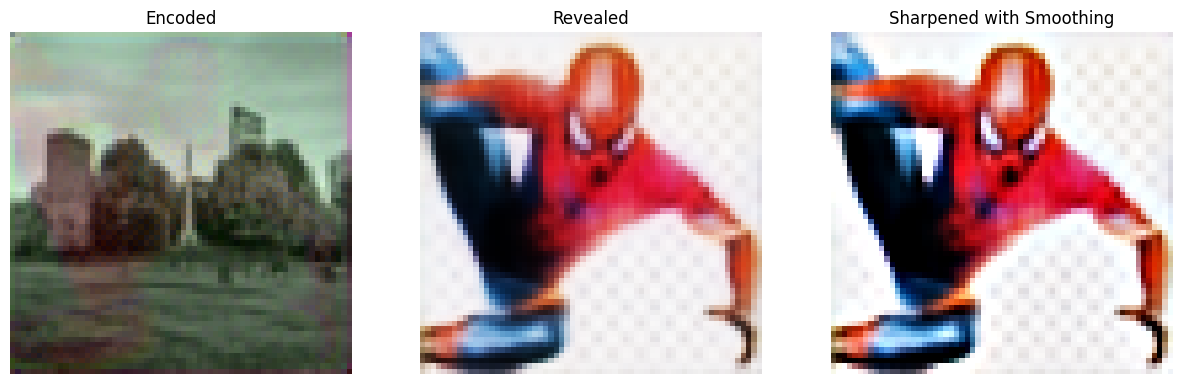

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def process_and_sharpen_with_smoothing(encoded_img_path, decoder):
    # Load the encoded image using plt
    encoded_image_array = plt.imread(encoded_img_path)

    # If the image has an alpha channel, consider removing it if the decoder expects 3 channels
    if encoded_image_array.shape[-1] == 4:
        encoded_image_array = encoded_image_array[..., :3]

    # Process the encoded image through the decoder
    revealed_img = decoder.predict(encoded_image_array[np.newaxis, ...])

    # Apply Gaussian smoothing followed by subtracting from the original image
    blurred_img = cv2.GaussianBlur(revealed_img[0], (0, 0), 3)
    sharpened_img = cv2.addWeighted(revealed_img[0], 1.5, blurred_img, -0.5, 0)

    # Plot the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(encoded_image_array)
    plt.title("Encoded")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(revealed_img[0])
    plt.title("Revealed")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sharpened_img)
    plt.title("Sharpened with Smoothing")
    plt.axis('off')

    plt.show()

# Example usage:
encoded_img_path = '/content/encoded_image2.png'  # Replace with the path to the encoded image
process_and_sharpen_with_smoothing(encoded_img_path, reveal_model1)